In [1]:
import h5py as hp
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import illustris_python as il
import matplotlib.gridspec as gspec
import matplotlib as mpl
import copy
from hc_lib.plots.fig_lib import FigureLibrary
tngpath = '/lustre/cosinga/L75n1820TNG/'
basepath = '/lustre/cosinga/hcolor/fig_md_analysis/'

In [2]:
fsr = hp.File(basepath+'HIXgalaxy/HIxGal_fieldnameR_spaceC_redshift.hdf5', 'r')
rfc = hp.File(basepath+'HIXgalaxy/HIxGal_redshiftR_fieldnameC_color.hdf5', 'r')
head = il.groupcat.loadHeader(tngpath+'output/', 99)
redshifts = []
for i in list(fsr.keys()):
    try:
        z = fsr[i].attrs['redshift']
    except KeyError:
        continue
    else:
        
        if z[0] not in redshifts:
            redshifts.append(z[0])

In [3]:
def get_match(props):
    keys = fsr.keys()
    matches = []
    for k in keys:
        is_match = True
        if 'x' in k:
            for p,v in props.items():
                try:
                    lval = fsr[k].attrs[p]
                    
                    is_match = (is_match and v in lval)
                except KeyError:
                    continue
            if is_match:
                matches.append(k)
    return matches

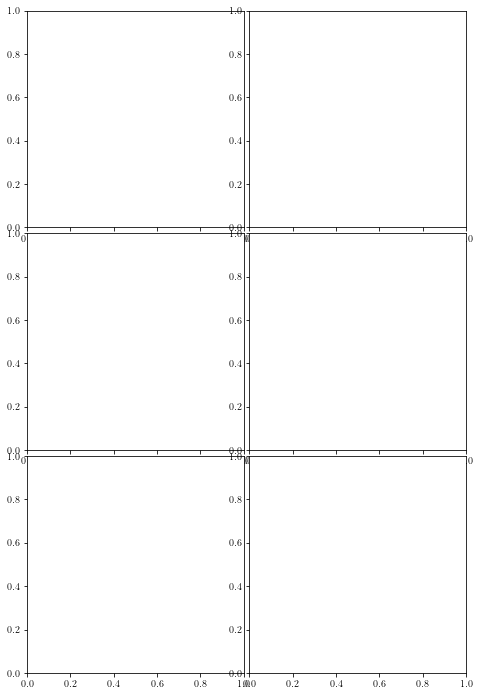

In [4]:
# redshift figure
nrows = 3
ncols = 2
xborder = 1
yborder = 1
panel_bt = 0.1
panel_length = 3


# border input can be either a list or single number
if isinstance(xborder, float) or isinstance(xborder, int):
    xborder = [xborder, xborder]
if isinstance(yborder, float) or isinstance(yborder, int):
    yborder = [yborder, yborder]
if isinstance(panel_bt, float) or isinstance(panel_bt, int):
    panel_bt = [panel_bt, panel_bt]
# creating Figure object

figwidth = panel_length * ncols + panel_bt[0] * (ncols - 1) + \
        xborder[0] + xborder[1]
figheight = panel_length * nrows + panel_bt[1] * (nrows - 1) + \
        yborder[0] + yborder[1]

fig = plt.figure(figsize=(figwidth, figheight))

# creating gridspec
gs = gspec.GridSpec(nrows, ncols)
plt.subplots_adjust(left= xborder[0]/figwidth, right=1-xborder[1]/figwidth,
        top=1-yborder[1]/figheight, bottom=yborder[0]/figheight,
        wspace=panel_bt[0]*ncols/figwidth, hspace=panel_bt[1]*nrows/figheight)

# making panels list
panels = []
for i in range(nrows):
    col_panels = []
    for j in range(ncols):
        col_panels.append(fig.add_subplot(gs[i, j]))

    panels.append(col_panels)

flib = FigureLibrary(fig=fig, panels=panels)
flib.panel_length = panel_length
flib.panel_bt = panel_bt
flib.xborder = xborder
flib.yborder = yborder
flib.figsize = [figwidth, figheight]
flib.has_cbar_col = False

In [5]:
keys_for_panels = np.empty((nrows,ncols), dtype=object)

fieldnames = ['hiptl','hiptl','hisubhalo']
spaces = ['real', 'redshift','redshift']
colors = ['red', 'blue']

# CHANGE WHEN MORE REDSHIFTS ARE CALCULATED
for i in range(nrows):
    for j in range(ncols):
        props = {'fieldname':fieldnames[i], 'space':spaces[i], 'color':colors[j]}
        keys_for_panels[i,j] = get_match(props)
        if fieldnames[i] == 'hiptl':
            vnprops = copy.copy(props)
            vnprops['fieldname'] = 'vn'
            keys_for_panels[i,j].extend(get_match(vnprops))


In [6]:
colors = ['orange', 'blue', 'red', 'teal']
def _plotItem(keys, prop, label, color):
    plot_pk = []
    for k in keys:
        wavenum = fsr[k]
        pk_key = k[:-1] + 'y'
        pk = fsr[pk_key]
        if prop in wavenum.attrs['redshift']:
            plot_wn = wavenum[:]
            plot_pk.append(pk[:])
    plot_pk = np.array(plot_pk)
    flib.plotFillPanel(idx, plot_wn, plot_pk, label = label, color=color)
    return plot_wn, plot_pk

def fake_other_redshifts(plot_wn, plot_pk):
    otherz = ['z=0.5', 'z=1.0', 'z=1.5']
    for i in range(len(otherz)):
#         print(plot_pk)
        plot_pk = plot_pk*1.5
#         print(plot_pk)
        flib.plotFillPanel(idx, plot_wn, plot_pk, label = otherz[i], color=colors[i + 1])
        
    return

for i in range(nrows):
    for j in range(ncols):
        idx = (i,j)
        keys = keys_for_panels[idx]
        count = 0
        for r in redshifts:
            wn, pk = _plotItem(keys, r, 'z=%.1f'%round(float(r)), colors[count])
            mink = wn[0]
            fake_other_redshifts(wn, pk)
            count +=1

        

In [7]:
box = head['BoxSize'] /1e3 * head['Time']

# axes
flib.xLimAdjustToNyquist(gridres=800, box=box, xleft=mink)
flib.flushYAxisToData()
flib.matchAxisLimits()
flib.logAxis('both')

# labels
rowlabels = ['Real-Space Particles', 'Redshift-Space Particles', 'Redshift-Space Galaxies']
collabels = ['Red Galaxies', 'Blue Galaxies']
flib.defaultAxesLabels()
flib.addLegend((0,1))
flib.addColLabels(collabels, in_panel=True)
flib.addRowLabels(rowlabels, pos = (0.5,0.95), va='top', ha = 'center')

#ticks
flib.changeTickDirection()
flib.removeDefaultTickLabels()


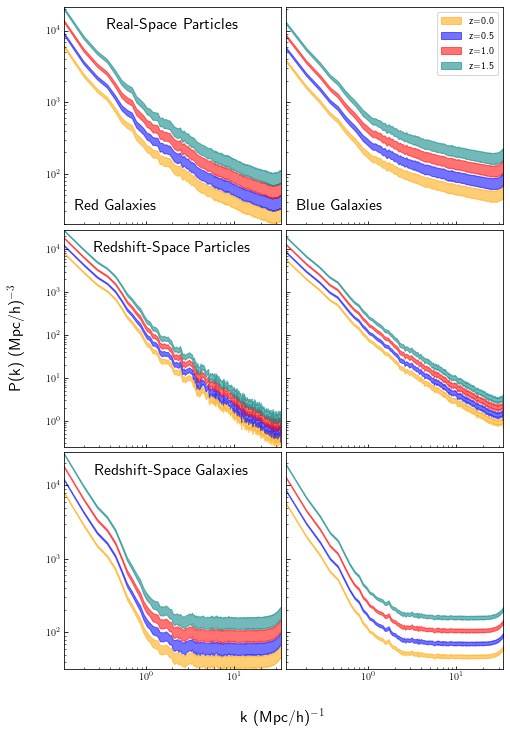

In [8]:
fig

In [9]:
fig.savefig('HIXGAL_redshift_evo_example.pdf')